In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from tqdm import tqdm
import datetime
#最终我们绘制的图形是每天从6点到23点的客流变化情况

In [2]:
root_path = '../Data' # Please set your data path here
raw_data = pd.read_csv(os.path.join(root_path, 'metroData_InOutFlow.csv'))
raw_data

,date,timeslot,startTime,endTime,station,inFlow,outFlow,CinFlow,HBOinFlow,NHBinFlow,CoutFlow,HBOoutFlow,NHBoutFlow
0,20170501,0,60000,61000,112,29,32,9,15,5,11,13,8
1,20170501,0,60000,61000,113,142,102,40,51,51,30,41,31
2,20170501,0,60000,61000,114,66,35,17,19,30,12,10,13
3,20170501,0,60000,61000,119,23,14,6,9,8,1,3,10
4,20170501,0,60000,61000,124,17,21,2,4,11,0,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788887,20170831,12545,225000,230000,2053,6,26,2,0,4,8,6,12
3788888,20170831,12545,225000,230000,2054,18,110,5,2,11,19,39,52
3788889,20170831,12545,225000,230000,2055,5,80,0,1,4,19,23,38
3788890,20170831,12545,225000,230000,2056,33,99,8,4,21,20,31,48


In [ ]:
def fetchData(targetStationID = 508, start_date = "2017-05-13", end_date = "2017-05-26"):
  
    timeslotPerDay = 17*6
    zero_date = '2017-05-01'

    start_slot = (datetime.datetime.strptime(start_date,"%Y-%m-%d")-datetime.datetime.strptime(zero_date,"%Y-%m-%d")).days * timeslotPerDay
    end_slot = ((datetime.datetime.strptime(end_date,"%Y-%m-%d")-datetime.datetime.strptime(zero_date,"%Y-%m-%d")).days+1) * timeslotPerDay -1
    print(start_slot, end_slot)
    #因为记录的时间为6点-23点，即0-17点，共17个小时，每10分钟一个时间片，所以每天有102个时间片
    #.days的作用是取出时间差的天数部分，然后乘以每天的时间槽数，得到从零点日期到开始日期的总时间槽数
    #end_slot多乘以1是因为包含end_date这一天的数据
    #总之，timeslot获得了从零点日期到指定日期的时间槽数
    Container = []
    tmp =[]

    for padding in range(6*6): # Initial 0-6 A.M.添加36个零值记录
        Container.append([0]*8)#8为每条记录的长度
        """
        返回一个NumPy数组，包含8列客流数据：
第0列：总进站流量（inFlow）
第1列：总出站流量（outFlow）
第2列：通勤进站流量（CinFlow）
第3列：工作日家庭出行进站流量（HOinFlow）
第4列：工作日其他出行进站流量（WOinFlow）
第5-7列：对应的出站流量
        """

    for iter in tqdm(range(len(raw_data.values))):#遍历数据集中的每一行
        line = raw_data.values[iter]
        timeSlot = line[1]

        if timeSlot < start_slot:# 如果当前时间槽小于开始时间槽，跳过该记录
            continue
        
        if timeSlot > end_slot:# 如果当前时间槽大于结束时间槽，添加6个零值记录后跳出循环
            for padding in range(1*6): # Final 11-12 P.M.
                Container.append([0]*8)
            break # get enough data

        if line[4] == targetStationID:
            Container.append(line[5:])#原来是13行，改为8行
            tmp.append(timeSlot)#记录时间槽

            if (timeSlot+1)%timeslotPerDay == 0 and timeSlot != end_slot:# 如果当前时间槽是一天的最后一个时间槽且不是结束时间槽，添加42个零值记录
                for padding in range(7*6):
                    Container.append([0]*8)

    Container = np.array(Container)
    return Container

In [3]:
def visStationFlow (Container, start_date = "2017-05-13", end_date = "2017-05-26"):
    mydates = pd.date_range(start=datetime.datetime.strptime(start_date,"%Y-%m-%d"), end=datetime.datetime.strptime(end_date,"%Y-%m-%d")+datetime.timedelta(days=1), freq="10T")[:-1]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

    ax1.plot(mydates, Container[:,0], label='inFlow', linewidth=0.8, color=(26/255,8/255,65/255))
    ax1.plot(mydates, Container[:,2], label='CinFlow', linewidth=0.8, color=(79/255,157/255,166/255))
    ax1.plot(mydates, Container[:,3], label='HOinFlow', linewidth=0.8, color=(255/255,173/255,90/255))
    ax1.plot(mydates, Container[:,4], label='WOinFlow', linewidth=0.8, color=(255/255,89/255,89/255))
    ax1.set_title('Inflow of Station')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Numbers')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
    ax1.legend(loc='upper left')
    ax1.grid()

    ax2.plot(mydates, Container[:,1], label='outFlow', linewidth=0.8, color=(26/255,8/255,65/255))
    ax2.plot(mydates, Container[:,5], label='CoutFlow', linewidth=0.8, color=(79/255,157/255,166/255))
    ax2.plot(mydates, Container[:,6], label='HOoutFlow', linewidth=0.8, color=(255/255,173/255,90/255))
    ax2.plot(mydates, Container[:,7], label='WOoutFlow', linewidth=0.8, color=(255/255,89/255,89/255))
    ax2.set_title('Outflow of Station')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Numbers')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
    ax2.set_xticklabels(ax1.get_xticklabels(),rotation=45)
    ax2.legend(loc='upper left')
    ax2.grid()

    # 显示图形
    plt.tight_layout()
    plt.show()

1224 2651


 21%|██        | 800904/3788892 [00:01<00:06, 452841.81it/s]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mydates = pd.date_range(start=datetime.datetime.strptime(start_date,"%Y-%m-%d"), end=datetime.datetime.strptime(end_date,"%Y-%m-%d")+datetime.timedelta(days=1), freq="10T")[:-1]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax1.get_xticklabels(),rotation=45)


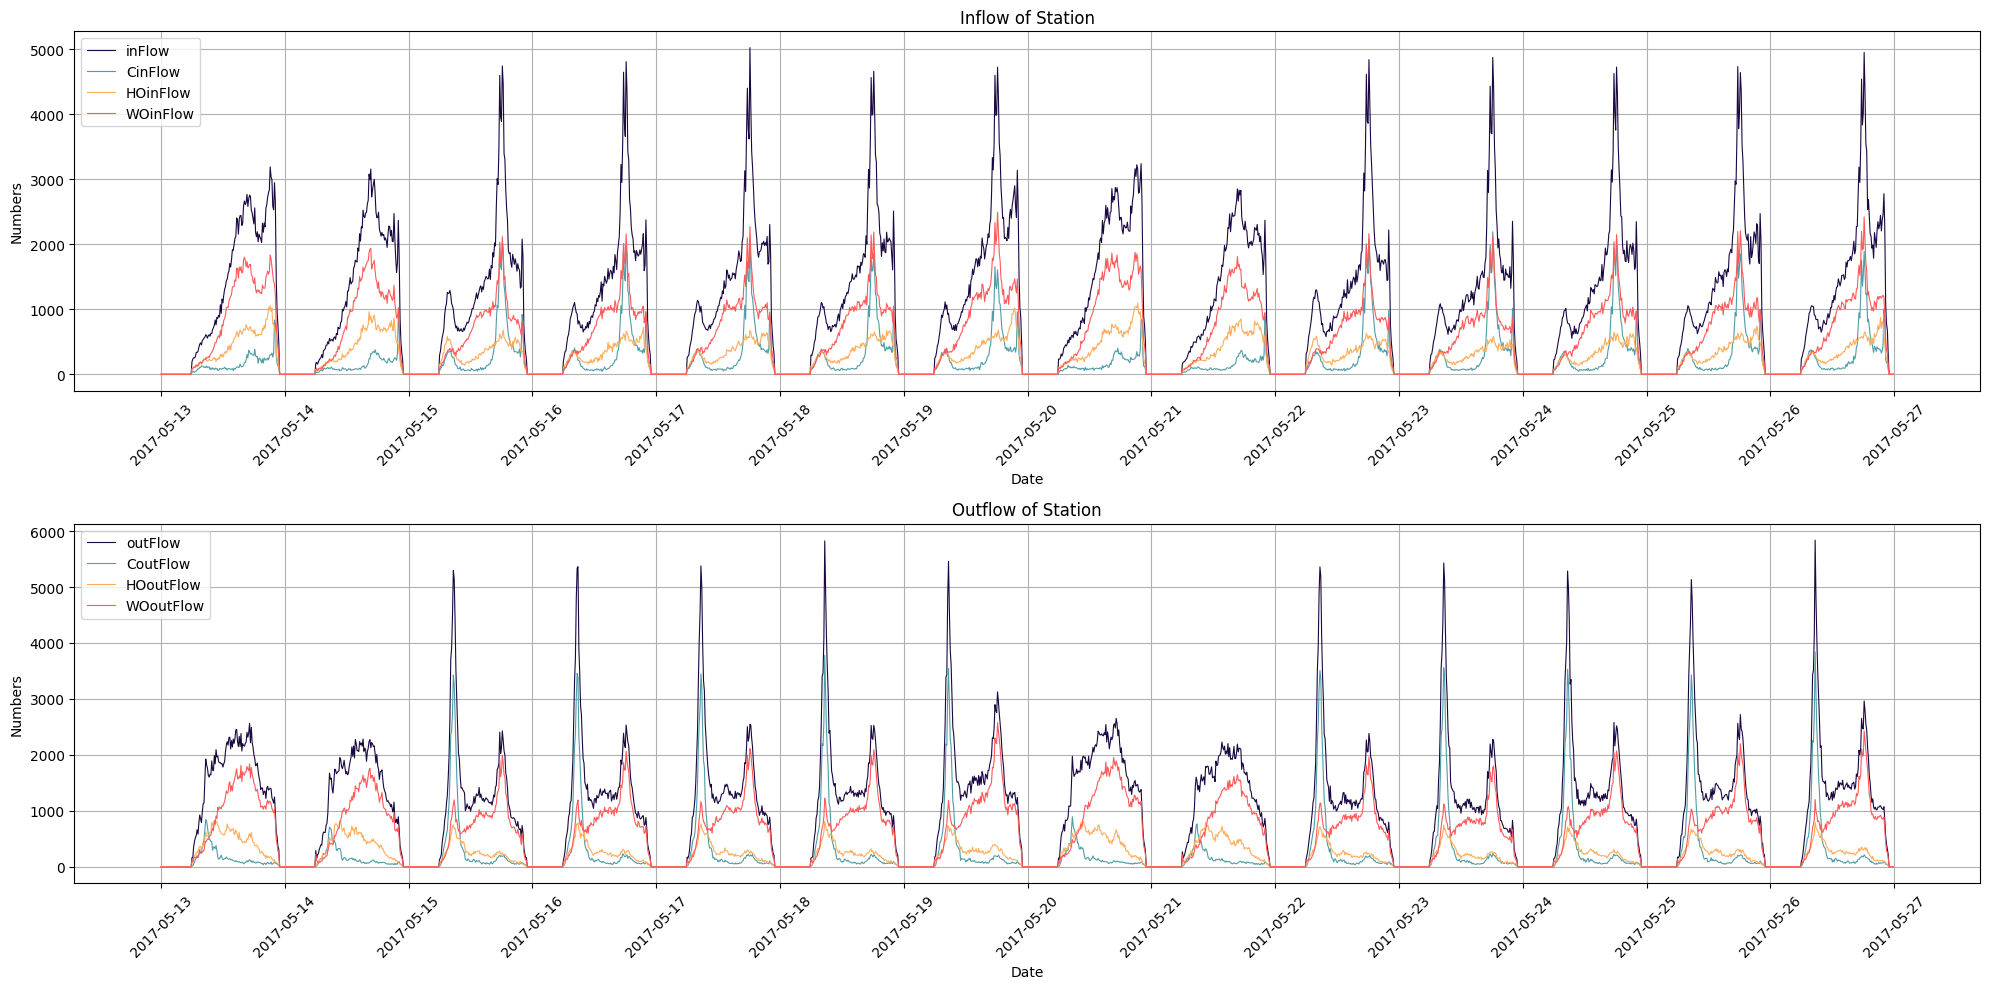

In [ ]:
targetStationID = 2035 # 人民广场
start_date = "2017-05-13"
end_date = "2017-05-26"
Container = fetchData(targetStationID, start_date, end_date)
visStationFlow (Container, start_date, end_date)


1224 2651


 21%|██        | 800904/3788892 [00:01<00:07, 426601.52it/s]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mydates = pd.date_range(start=datetime.datetime.strptime(start_date,"%Y-%m-%d"), end=datetime.datetime.strptime(end_date,"%Y-%m-%d")+datetime.timedelta(days=1), freq="10T")[:-1]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax1.get_xticklabels(),rotation=45)


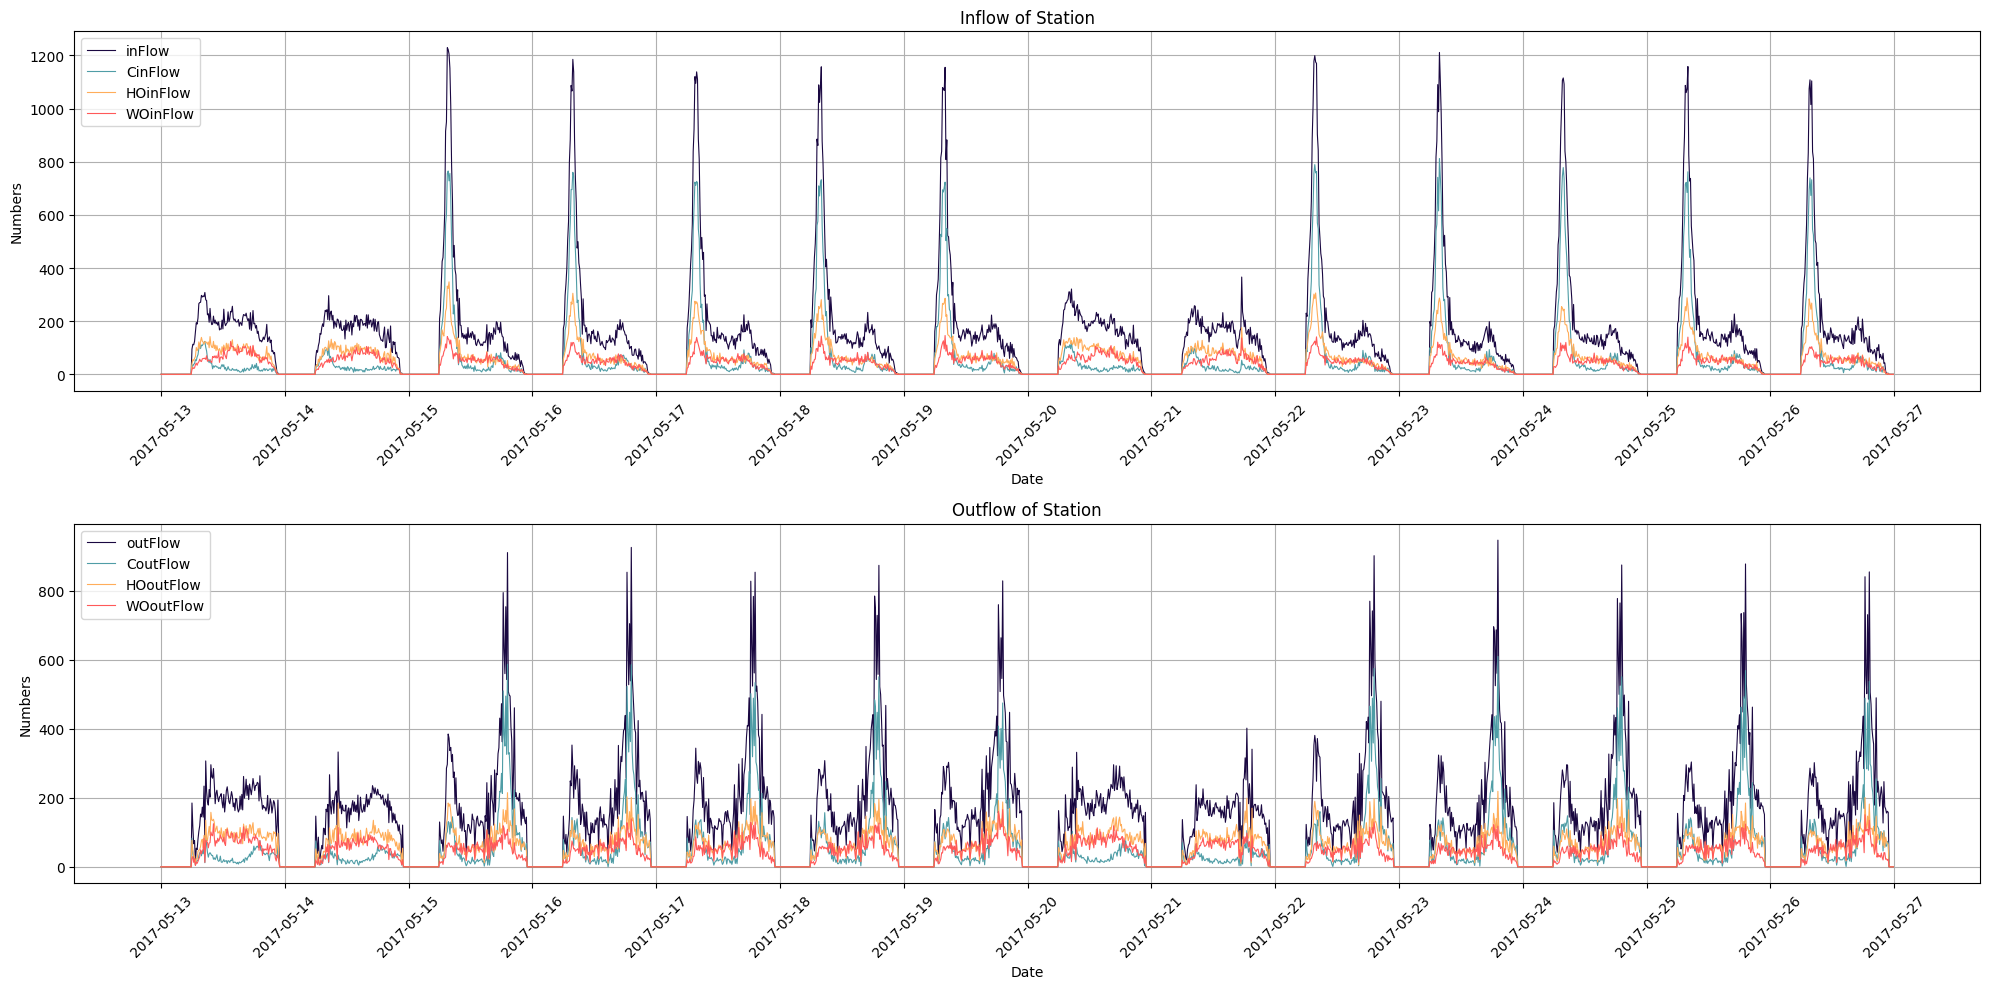

In [8]:
targetStationID = 725 # 顾村公园
start_date = "2017-05-13"
end_date = "2017-05-26"
Container = fetchData(targetStationID, start_date, end_date)
visStationFlow (Container, start_date, end_date)

1224 12443


 99%|█████████▉| 3758088/3788892 [00:09<00:00, 415650.58it/s]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mydates = pd.date_range(start=datetime.datetime.strptime(start_date,"%Y-%m-%d"), end=datetime.datetime.strptime(end_date,"%Y-%m-%d")+datetime.timedelta(days=1), freq="10T")[:-1]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20268\2980755652.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax1.get_xticklabels(),rotation=45)


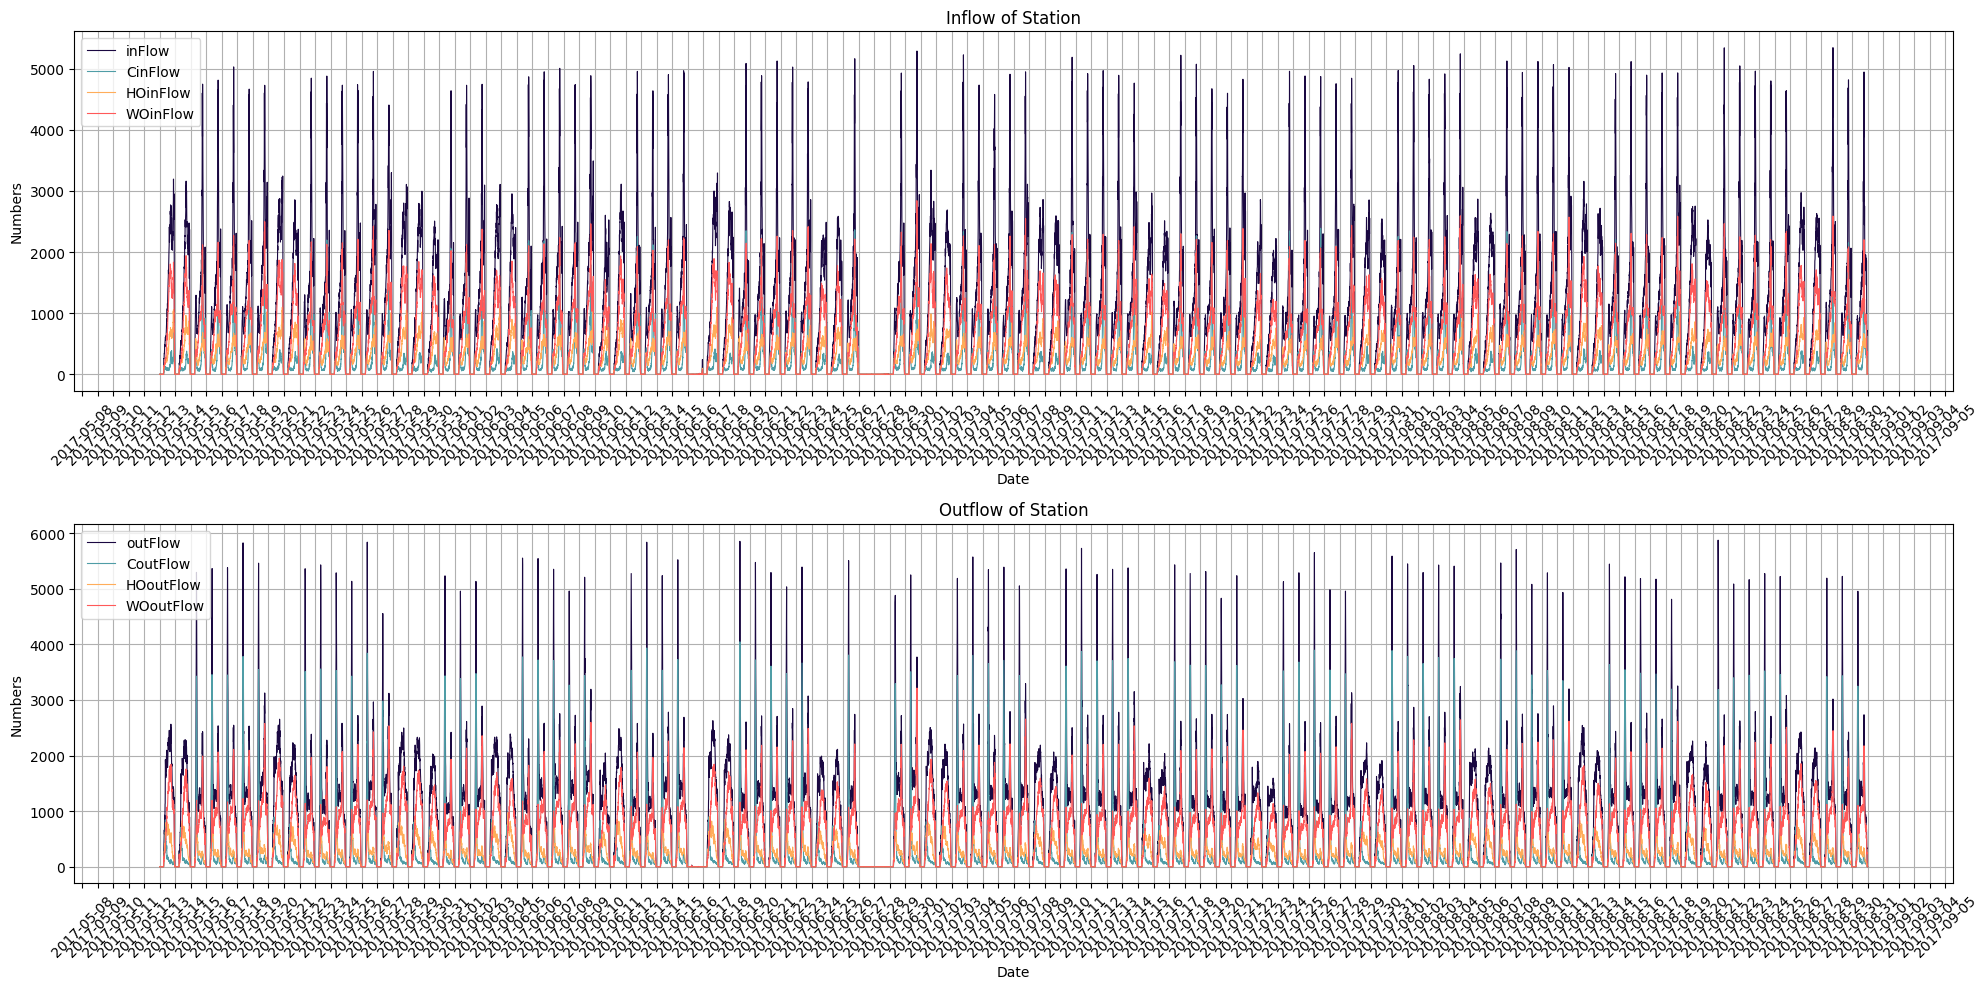

In [9]:
targetStationID = 2035 # 人民广场
start_date = "2017-05-13"
end_date = "2017-08-30"
Container = fetchData(targetStationID, start_date, end_date)
visStationFlow (Container, start_date, end_date)